In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
colors = sns.color_palette()
from rhessys import utilities as rut
import statsmodels.formula.api as sm

In [2]:
niwot = pd.read_pickle('./data/niwot_new.pcl')

In [3]:
niwot.SWE *= 0.001 # convert from mm to m

## Bring in the other climate data

In [4]:
crn = pd.read_pickle('../greenness_timing/data/boulder_co.pcl')
crn.P *= 0.001 # mm to m
crn.loc[np.isnan(crn.P)==True,'P']=0.

In [5]:
crn['wateryear'] = crn.index.map(rut.wateryear)
crn['DOWY'] = crn.index.map(rut.DOWY)

In [6]:
crn = crn.loc[(crn.wateryear>=2004)&(crn.wateryear<=2014)] # crop the data

In [7]:
crn.loc[crn.DOWY==366] = np.NaN
crn.dropna(subset=['P'],inplace=True)

In [8]:
crn['accumP'] = np.NaN
for wy in np.unique(crn.wateryear):
    crn.loc[crn.wateryear==wy,'accumP'] = crn.loc[crn.wateryear==wy,'P'].cumsum()

In [9]:
crn2 = crn.groupby(by='DOWY').mean()

In [16]:
crn.loc[crn.P>0,'P'].mean()*1000

5.2647959183673469

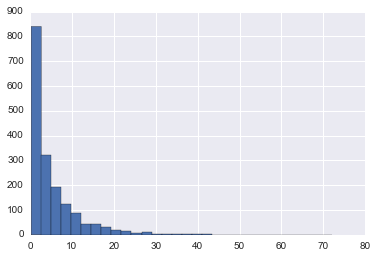

In [22]:
plt.hist(crn.loc[crn.P>0,'P'].as_matrix()*1000,30);

In [17]:
niwot.loc[niwot.snowmelt>0,'snowmelt'].mean()

9.8886996024985798

(0, 80)

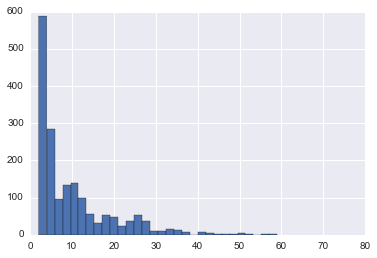

In [21]:
plt.hist(niwot.loc[niwot.snowmelt>0,'snowmelt'].as_matrix(),30);
plt.xlim(0,80)

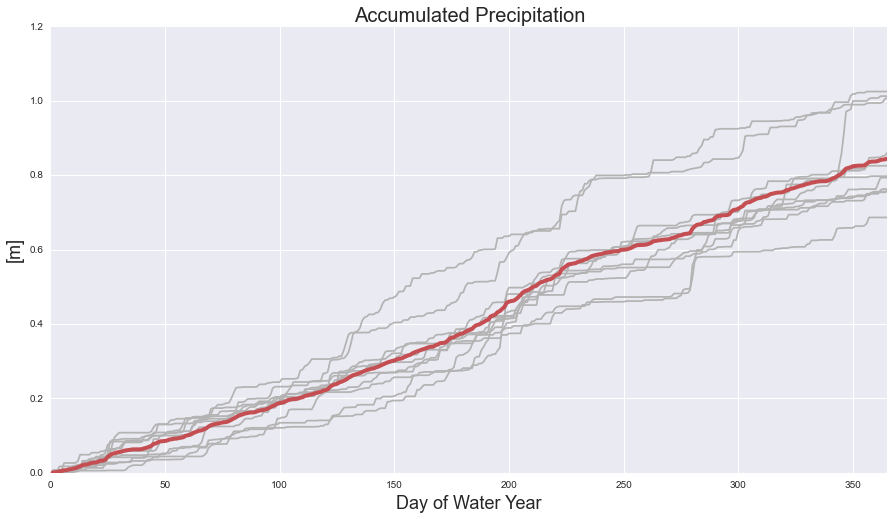

In [10]:
plt.figure(figsize=(15,8))
for wy in np.unique(crn.wateryear):
    plt.plot(crn.loc[crn.wateryear==wy,'DOWY'],crn.loc[crn.wateryear==wy,'accumP'],'-',c='0.7')
plt.plot(crn2.index,crn2.accumP,lw=4, c= colors[2])
plt.xlim(0,365)
plt.title('Accumulated Precipitation',fontsize = 20)
plt.ylabel('[m]', fontsize=18)
plt.xlabel('Day of Water Year', fontsize=18)
#plt.savefig('./figures/mean_precip.png',dpi=300,bbox_inches='tight')

## Create a Mean Nievograph

In [11]:
# do something about leap years...
niwot.loc[niwot.dowy==366] = np.NaN # set this equal to nan
niwot.dropna(subset=['dowy'],inplace=True) # and delete it

In [12]:
niwot2 = niwot.groupby(by='dowy').mean()

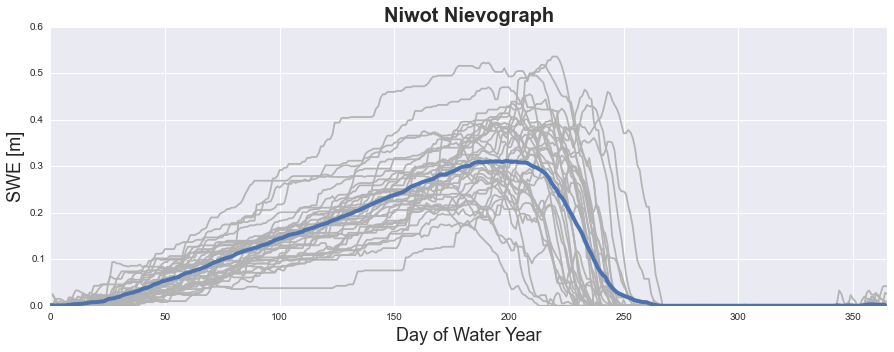

In [13]:
plt.figure(figsize=(15,5))
for wy in np.unique(niwot.wateryear):
    plt.plot(niwot.loc[niwot.wateryear==wy,'dowy'],niwot.loc[niwot.wateryear==wy,'SWE'],'-',c='0.7')
plt.plot(niwot2.SWE,lw=4, c=colors[0])
plt.xlim(0,365)
plt.xlabel('Day of Water Year', fontsize=18)
plt.ylabel('SWE [m]', fontsize = 18)
plt.title('Niwot Nievograph', fontsize=20, fontweight='bold')
#plt.savefig('./figures/mean_swe.png',dpi=300,bbox_inches='tight')

## Find the distribution of snowmelt rates

### Snowmelt Rate Per Year

In [14]:
header = ['averageMR','peakSWE','DatepeakSWE','DateNS','accumSeasDate','P']
sm2 = pd.DataFrame(index=np.unique(niwot.wateryear)[:-1],columns=header)

In [15]:
for wy in np.unique(niwot.wateryear)[:-1]:
    sm2.loc[sm2.index==wy,'averageMR'] = niwot.loc[(niwot.wateryear == wy) & (niwot.snowmelt>0),'snowmelt'].mean()
    sm2.loc[sm2.index==wy,'peakSWE'] = niwot.loc[niwot.wateryear == wy,'SWE'].max()
    sm2.loc[sm2.index==wy,'DatepeakSWE'] = niwot.loc[niwot.wateryear == wy,'SWE'].argmax()
    sm2.loc[sm2.index==wy,'DateNS'] = niwot.loc[(niwot.wateryear == wy)&(niwot.index>=sm2.loc[sm2.index==wy,'DatepeakSWE']),'SWE'].argmin()
    sm2.loc[sm2.index==wy,'accumSeasDate'] = niwot.loc[(niwot.wateryear ==wy)&(niwot.index<sm2.loc[sm2.index==wy,'DatepeakSWE'])&(niwot.SWE>0)].index.min()
    sm2.loc[sm2.index==wy,'P'] = np.nansum(niwot.loc[niwot.wateryear == wy,'P'])
    
sm2['DOWYpeakSWE'] = sm2.DatepeakSWE.map(rut.DOWY)
sm2['DOWYnoSnow'] = sm2.DateNS.map(rut.DOWY)
sm2['DOAS'] = sm2.accumSeasDate.map(rut.DOWY)

In [16]:
sm2.to_pickle('./data/niwot_stats.pcl')

In [17]:
dates = []
snowmelts = []
DOAS = []

for wy in np.unique(niwot.wateryear)[:-1]: # loop through each water year and extract each snowmelt season
    
    strt = sm2.loc[sm2.index==wy,'DatepeakSWE'].as_matrix()[0] # get the date of peak SWE
    nd = sm2.loc[sm2.index==wy,'DateNS'].as_matrix()[0] # get the date of no snow
    
    smelt = list(niwot.loc[strt:nd,'snowmelt'])
    
    snowmelts.extend(list(niwot.loc[strt:nd,'snowmelt'])) # pull out the snowmelts
    DOAS.extend(list(np.arange(1,len(smelt)+1))) # create an array of ablation season days
    dates.extend(list(pd.date_range(strt,nd,freq='D'))) # create an array of actual days

In [18]:
AS = pd.DataFrame({'snowmelt':snowmelts,'DOAS':DOAS,'date':dates})
AS['DOWY'] = AS.date.map(rut.DOWY)
AS['DOWY2'] = AS.DOWY**2

                            OLS Regression Results                            
Dep. Variable:               snowmelt   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     902.1
Date:                Tue, 14 Jul 2015   Prob (F-statistic):          1.51e-246
Time:                        15:51:27   Log-Likelihood:                -4810.7
No. Observations:                1304   AIC:                             9625.
Df Residuals:                    1302   BIC:                             9636.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
DOWY          -0.1020      0.014     -7.125      0.0

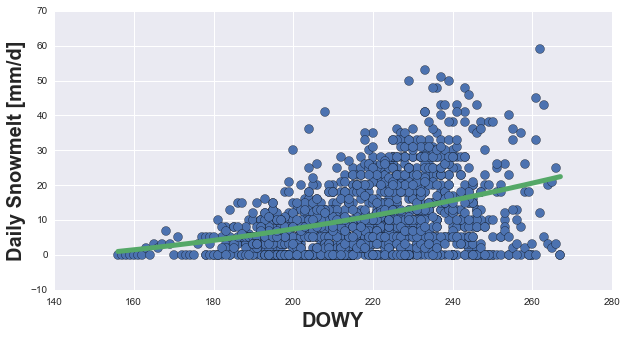

In [23]:
mod = sm.OLS.from_formula('snowmelt ~ DOWY + DOWY2 - 1',AS.loc[AS.snowmelt>=0]).fit()
print mod.summary()

dmin = AS.DOWY.min()
dmax = AS.DOWY.max()

xs = np.linspace(dmin,dmax,500)
plt.figure(figsize=(10,5))
plt.scatter(AS.loc[AS.snowmelt>=0].DOWY,AS.loc[AS.snowmelt>=0].snowmelt,s=80,c=colors[0])
plt.plot(xs,(xs*-0.1028)+(xs**2)*0.0007,'-',c=colors[1],lw=5)
plt.xlabel('DOWY', fontsize=20,weight='bold')
plt.ylabel('Daily Snowmelt [mm/d]', fontsize=20,weight='bold')
plt.savefig('./figures/SMR_DOWY.png', dpi = 300, bbox_inches='tight')

In [27]:
print '***Day of Water Year Peak SWE***'
print 'Mean DOWY Peak SWE:',sm2.DOWYpeakSWE.mean()
print 'DOWY Peak SWE STDEV:',sm2.DOWYpeakSWE.std()
print
print '***Peak SWE***'
print 'Mean Peak SWE:',sm2.peakSWE.mean(),'[m]'
print 'Peak SWE STDEV:',sm2.peakSWE.std(),'[m]'
print
print '***Snowmelt Rate***'
print 'Mean Snowmelt Rate:',sm2.averageMR.mean(),'[mm/d]'
print 'Snowmelt Rate STDEV:',sm2.averageMR.std(),'[mm/d]'

***Day of Water Year Peak SWE***
Mean DOWY Peak SWE: 199.470588235
DOWY Peak SWE STDEV: 18.1111639673

***Peak SWE***
Mean Peak SWE: 0.367294117647 [m]
Peak SWE STDEV: 0.0903315540734 [m]

***Snowmelt Rate***
Mean Snowmelt Rate: 10.2228332545 [mm/d]
Snowmelt Rate STDEV: 2.67612303286 [mm/d]


## Define a set of scaling relationships

In [28]:
def DOWY2cal(x):
    td = pd.datetools.timedelta(x.dowy-1)
    ref = pd.datetime(int(x.ref)-1,10,1)
    
    nd = ref+td
    
    return nd

In [29]:
def DOPEAKSWE2cal(x):
    td = pd.datetools.timedelta(x.TpeakSWE-1)
    ref = pd.datetime(int(x.ref)-1,10,1)
    
    nd = ref+td
    
    return nd

In [30]:
def DONS2cal(x):
    td = pd.datetools.timedelta(x.Tnosnow-1)
    ref = pd.datetime(int(x.ref)-1,10,1)
    
    nd = ref+td
    
    return nd

In [31]:
def DOAS2cal(x):
    td = pd.datetools.timedelta(x.DOAS-1)
    ref = pd.datetime(int(x.ref)-1,10,1)
    
    nd = ref+td
    
    return nd

In [32]:
def getmonth(index):
    return index.month

def getday(index):
    return index.day

def getyear(index):
    return index.year

In [33]:
def gensm(DOWY):
    '''Use the DOWY - snowmelt rate relationship to compute a snowmelt value based on the DOWY
    DOWY: day of water year'''
    val = (DOWY*-0.1028)+(DOWY**2)*0.0007 # compute the snowmelt rate
    noise = 2.676 * np.random.randn(1) # create some noise with the same standard deviation as the observed snowmelt events
    val += noise
    if val < 0.:
        val = 0.
    val *= val*0.001 # convert mm/d to m/d
    return val

In [34]:
print ((np.percentile(sm2.averageMR,90)-sm2.averageMR.mean())*1.5)+sm2.averageMR.mean()
print sm2.averageMR.mean()-((sm2.averageMR.mean()-np.percentile(sm2.averageMR,10))*1.5)

12.9238125053
6.02648784115


In [35]:
sm2.averageMR.mean()

10.222833254521333

In [36]:
TpeakSWEs = np.arange(172,232,1) # Range for the timing of peak SWE
TnoSnow = np.arange(223,262,1) # range of the timing of no snow
peakswe = np.linspace(0.201,0.519,65) # range of peak SWE

In [37]:
TPS = []
TNS = []
PS = []
for i in TpeakSWEs:
    for k in TnoSnow:
        for d in peakswe:
            TPS.append(i)
            TNS.append(k)
            PS.append(d)

params = pd.DataFrame({'TpeakSWE':TPS,'Tnosnow':TNS,'peakSWE':PS})

In [38]:
# drop rows with imposible combinations
params['SMR'] = params['peakSWE']/(params['Tnosnow']-params['TpeakSWE']) # compute the average snowmelt rate
params.loc[(params['Tnosnow']-params['TpeakSWE'])<1] = np.NaN
params.loc[params.SMR>12.9238*0.001] = np.NaN # remove crazy big snowmelt rates
params.dropna(inplace=True)

In [39]:
len(params)

106676

In [40]:
# calculate a bunch of things
params['ref'] = 2008 # add a reference water year
params['date_ONS'] = params.apply(DONS2cal, axis=1) # compute the day of water year for no snow
params['DOAS'] = 15 # compute the day of water year for the beginning of accumulation
params['date_AS'] = params.apply(DOAS2cal, axis=1) # compute the date for the beginning of accumulation
params['idx'] = np.arange(0,len(params)) # add an index column
params['date_peakSWE']=params.apply(DOPEAKSWE2cal,axis=1)

In [96]:
params.head()

,Tnosnow,TpeakSWE,peakSWE,SMR,ref,date_ONS,DOAS,date_AS,idx,date_peakSWE
0,223,172,0.201000,0.003941,2008,2008-05-10,15,2007-10-15,0,2008-03-20
1,223,172,0.205969,0.004039,2008,2008-05-10,15,2007-10-15,1,2008-03-20
2,223,172,0.210938,0.004136,2008,2008-05-10,15,2007-10-15,2,2008-03-20
3,223,172,0.215906,0.004233,2008,2008-05-10,15,2007-10-15,3,2008-03-20
4,223,172,0.220875,0.004331,2008,2008-05-10,15,2007-10-15,4,2008-03-20


In [97]:
params.to_pickle('./data/params_smex2.pcl')

In [98]:
def genSMcurve(x):
    
    #peakSWE = 0.378 #[m]
    #snowmeltrate = 11.28205 * 0.001 #[m/d]
    #DOWYpeakSWE = 201 #[DOWY]
    
    PSWE = x.peakSWE # new peak SWE [m]
    SMR = x.SMR # new snowmelt rate [m/d]
    tPeakSWE = x.TpeakSWE # new day of water year of peak SWE [DOWY]
    tNoSnow = x.Tnosnow # the day of water year of no snow
    
    # Compute the number of days of the snowmelt season
    #n = np.ceil(float(PSWE)/float(SMR)) #days
    
    # Generate a list of DOWY
    days = np.arange(tPeakSWE,tNoSnow)
    
    res = pd.DataFrame({'dowy':days}) # create a data frame
    res['sm'] = res.dowy.map(gensm) # map the snowmelt function onto the DF returns sm in [m/d]
    
    meanSMR = np.mean(res.sm) # compute the mean snowmelt rate [m/d]\
    #print meanSMR
    diff = SMR/meanSMR # compute the ratio [1]
    #print diff
    res['sm'] *= diff # scale the snowmelt curve to match the correct one
    
    # handle the dates
    res['ref'] = 2008 # create a reference year column
    res['date'] = res.apply(DOWY2cal,axis=1)
    res['year'] = res.date.map(getyear)
    res['month'] = res.date.map(getmonth)
    res['day'] = res.date.map(getday)
    res['hour'] = 1. # create an hour column
    
    # create an array for export
    
    years = res.year.as_matrix()
    months = res.month.as_matrix()
    days = res.day.as_matrix()
    hours = res.hour.as_matrix()
    sm = res.sm.as_matrix()
    
    # reshape the arrays
    years = np.reshape(years,[len(years),1]) 
    months = np.reshape(months,[len(months),1]) 
    days = np.reshape(days,[len(days),1]) 
    hours = np.reshape(hours,[len(hours),1]) 
    sm = np.reshape(sm,[len(sm),1]) 
    
    out = np.concatenate((years,months,days,hours,sm),axis=1) # concat the arrays
    
    filenum = int(x.idx)
    
    np.savetxt('/RHESSys/ComoCreek_new/clim/smexperiment/smex2/hourly/scen_'+str(filenum)+'.snow_melt_input',out,fmt='%i %i %i %i %10.8f',
              comments='',header=str(len(years)))

## Test

In [99]:
params.apply(genSMcurve,axis =1);
print 'Done!'

Done!


## Generate rain time series the coorespond to the snowmelt scenarios

In [100]:
def genrain(x):
    
    rain = crn.loc['2007-10-1':'2008-10-15','P'].copy() # subset the P, units should be m
    rain2 = crn.loc['2007-10-1':'2008-10-15','P'].copy()
    
    strt = x.date_peakSWE # beginning of snowmelt
    strt2 = x.date_AS # beginning of the snow season
    nd = x.date_ONS-pd.datetools.timedelta(1) # end of the snow season
    
    
    rain[str(strt):str(nd)] = 0. # zero the rain for peak swe to DONS, so it builds a snowpack 
    rain2[str(strt2):str(nd)] = 0. # zero the rain for the snow season
    
    header = '2007 10 1'
    
    rn = rain.as_matrix()
    rn = np.reshape(rn,[len(rn),1])
    
    filenum = int(x.idx)
    
    np.savetxt('/RHESSys/ComoCreek_new/clim/smexperiment/smex2/daily/boulder_crn_'+str(filenum)+'.rain',
               rn,comments='',header=header,fmt='%10.8f')
    
    return rain2['2007-10-01':'2008-9-30'].sum() # return the total rain for the water year

### Test

In [101]:
crn = pd.read_pickle('../greenness_timing/data/boulder_co.pcl')
crn.P *= 0.001 # mm to m
crn.loc[np.isnan(crn.P)==True,'P']=0.

In [102]:
params['MAP'] = params.apply(genrain,axis=1)
print 'Done!'

Done!


In [103]:
params.head()

,Tnosnow,TpeakSWE,peakSWE,SMR,ref,date_ONS,DOAS,date_AS,idx,date_peakSWE,MAP
0,223,172,0.201000,0.003941,2008,2008-05-10,15,2007-10-15,0,2008-03-20,0.341
1,223,172,0.205969,0.004039,2008,2008-05-10,15,2007-10-15,1,2008-03-20,0.341
2,223,172,0.210938,0.004136,2008,2008-05-10,15,2007-10-15,2,2008-03-20,0.341
3,223,172,0.215906,0.004233,2008,2008-05-10,15,2007-10-15,3,2008-03-20,0.341
4,223,172,0.220875,0.004331,2008,2008-05-10,15,2007-10-15,4,2008-03-20,0.341


In [104]:
params.to_pickle('./data/params_smex2.pcl')

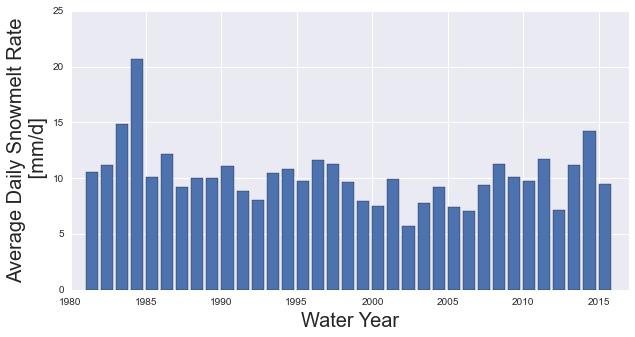

In [23]:
plt.figure(figsize=(10,5))
plt.bar(sm.index,sm.average)
plt.xlim(1980,2017);
plt.xlabel('Water Year', fontsize=20)
plt.ylabel('Average Daily Snowmelt Rate \n [mm/d]',fontsize=20);

## Plot the distribution of Snowmelt Rates

 Mean 9.88863636364
SD 9.35559202701


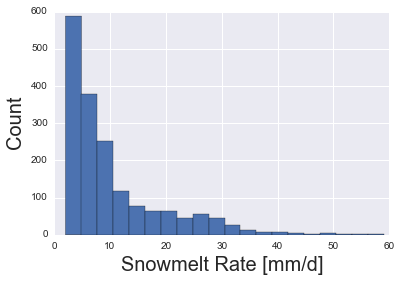

In [33]:
plt.hist(niwot.loc[niwot.snowmelt>0,'snowmelt'],20);
plt.xlabel('Snowmelt Rate [mm/d]',fontsize=20)
plt.ylabel('Count', fontsize=20);

print 'Mean',niwot.loc[niwot.snowmelt>0,'snowmelt'].mean()
print 'SD',niwot.loc[niwot.snowmelt>0,'snowmelt'].std()

In [411]:
30.*0.001

0.03

## Find Years with Peak SWE and Accumulated P simular to the Average

In [22]:
wy = 1990

1991


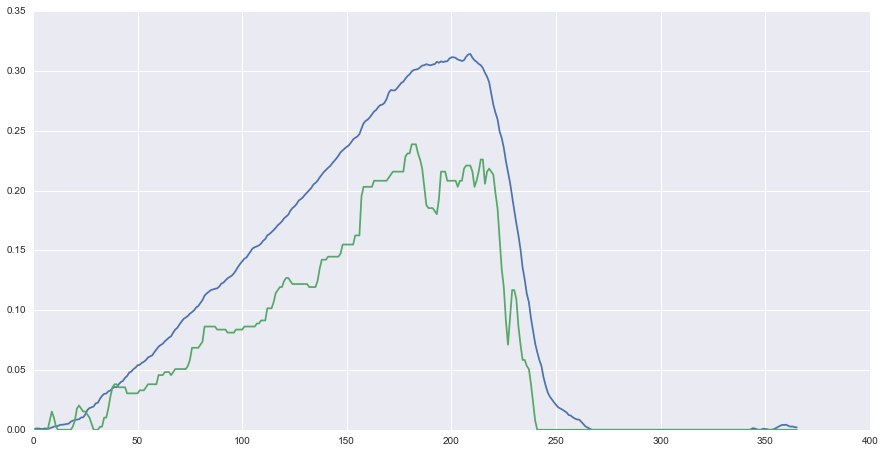

In [24]:
plt.figure(figsize=(15,7.5))
plt.plot(niwot2.index,niwot2.swe)
plt.plot(niwot.loc[niwot.wateryear==wy,'DOWY'],niwot.loc[niwot.wateryear==wy,'swe'])
print wy
wy += 1

WY 2008 looks pretty good

2008


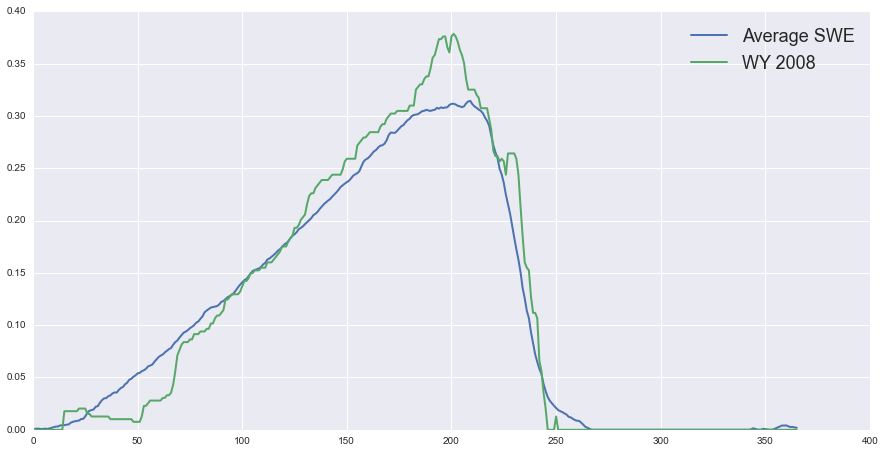

In [101]:
wy = 2008
plt.figure(figsize=(15,7.5))
plt.plot(niwot2.index,niwot2.swe,lw=2)
plt.plot(niwot.loc[niwot.wateryear==wy,'DOWY'],niwot.loc[niwot.wateryear==wy,'swe'],lw=2)
plt.legend(['Average SWE','WY 2008'], fontsize = 18)
print wy

In [33]:
sm2.loc[2008]

averageMR                   11.28205
peakSWE                        0.378
DatepeakSWE      2008-04-18 00:00:00
DateNS           2008-06-02 00:00:00
accumSeasDate    2007-10-15 00:00:00
DOWYpeakSWE                      201
DOWYnoSnow                       246
DOAS                              15
Name: 2008.0, dtype: object

## Make a plot of how precip is handled in the scenario

In [50]:
def genrain(x):
    
    rain = crn.loc['2007-10-1':'2008-10-15','P'].copy() # subset the P, units should be m
    rain2 = crn.loc['2007-10-1':'2008-10-15','P'].copy()
    
    strt = x.date_peakSWE # beginning of snowmelt
    strt2 = x.date_AS # beginning of the snow season
    nd = x.date_ONS-pd.datetools.timedelta(1) # end of the snow season
    
    
    rain[str(strt):str(nd)] = 0. # zero the rain for peak swe to DONS, so it builds a snowpack 
    rain2[str(strt2):str(nd)] = 0. # zero the rain for the snow season
    
    header = '2007 10 1'
    
    rn = rain.as_matrix()
    rn = np.reshape(rn,[len(rn),1])
    
    filenum = int(x.idx)
    
    #np.savetxt('/RHESSys/ComoCreek_new/clim/smexperiment/smex2/daily/boulder_crn_'+str(filenum)+'.rain',
               #rn,comments='',header=header,fmt='%10.8f')
    
    return [rain2['2007-10-01':'2008-9-30'].sum(),rain,rain2] # return the total rain for the water year

In [100]:
def genSMcurve(x):
    
    #peakSWE = 0.378 #[m]
    #snowmeltrate = 11.28205 * 0.001 #[m/d]
    #DOWYpeakSWE = 201 #[DOWY]
    
    PSWE = x.peakSWE # new peak SWE [m]
    SMR = x.SMR # new snowmelt rate [m/d]
    tPeakSWE = x.TpeakSWE # new day of water year of peak SWE [DOWY]
    tNoSnow = x.Tnosnow # the day of water year of no snow
    
    # Compute the number of days of the snowmelt season
    #n = np.ceil(float(PSWE)/float(SMR)) #days
    
    # Generate a list of DOWY
    days = np.arange(tPeakSWE,tNoSnow)
    
    res = pd.DataFrame({'dowy':days}) # create a data frame
    res['sm'] = res.dowy.map(gensm) # map the snowmelt function onto the DF returns sm in [m/d]
    
    meanSMR = np.mean(res.sm) # compute the mean snowmelt rate [m/d]\
    #print meanSMR
    diff = SMR/meanSMR # compute the ratio [1]
    #print diff
    res['sm'] *= diff # scale the snowmelt curve to match the correct one
    
    # handle the dates
    res['ref'] = 2008 # create a reference year column
    res['date'] = res.apply(DOWY2cal,axis=1)
    res['year'] = res.date.map(getyear)
    res['month'] = res.date.map(getmonth)
    res['day'] = res.date.map(getday)
    res['hour'] = 1. # create an hour column
    
    # create an array for export
    
    years = res.year.as_matrix()
    months = res.month.as_matrix()
    days = res.day.as_matrix()
    hours = res.hour.as_matrix()
    sm = res.sm.as_matrix()
    
    # reshape the arrays
    years = np.reshape(years,[len(years),1]) 
    months = np.reshape(months,[len(months),1]) 
    days = np.reshape(days,[len(days),1]) 
    hours = np.reshape(hours,[len(hours),1]) 
    sm = np.reshape(sm,[len(sm),1]) 
    
    out = np.concatenate((years,months,days,hours,sm),axis=1) # concat the arrays
    
    filenum = int(x.idx)
    
    #np.savetxt('/RHESSys/ComoCreek_new/clim/smexperiment/smex2/hourly/scen_'+str(filenum)+'.snow_melt_input',out,fmt='%i %i %i %i %10.8f',
              #comments='',header=str(len(years)))
        
    return res

In [51]:
P,rain,rain2 = genrain(params.loc[17824])

In [101]:
sm = genSMcurve(params.loc[17828])

In [52]:
rain = pd.DataFrame({'rain':rain})

In [53]:
rain['rain2'] = rain2 

In [55]:
rain['accum_rain'] = rain.rain.cumsum()
rain['accum_rain2'] = rain.rain2.cumsum()

In [79]:
colors = sns.color_palette()

In [86]:
par = params.loc[17824]

In [103]:
sm['accum_sm'] = sm.sm.cumsum()

In [113]:
rain

,rain,rain2,accum_rain,accum_rain2
date,,,,
2007-10-01,0.0000,0.0000,0.0000,0.0000
2007-10-02,0.0068,0.0068,0.0068,0.0068
2007-10-03,0.0000,0.0000,0.0068,0.0068
2007-10-04,0.0000,0.0000,0.0068,0.0068
2007-10-05,0.0000,0.0000,0.0068,0.0068
2007-10-06,0.0000,0.0000,0.0068,0.0068
2007-10-07,0.0000,0.0000,0.0068,0.0068
2007-10-08,0.0000,0.0000,0.0068,0.0068
2007-10-09,0.0000,0.0000,0.0068,0.0068


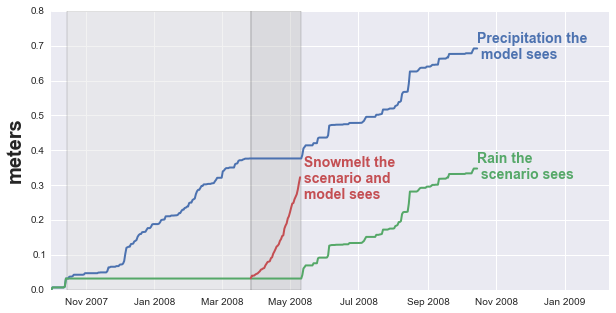

In [126]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.plot(rain.index,rain.accum_rain,lw=2)
ax1.text(rain.index.max(),rain.accum_rain.max()-0.027,'Precipitation the \n model sees',
         fontsize = 14, color = colors[0], weight = 'bold')

ax1.plot(rain.index,rain.accum_rain2,lw=2)
ax1.text(rain.index.max(),rain.accum_rain2.max()-0.027,'Rain the \n scenario sees',
         fontsize = 14, color = colors[1], weight = 'bold')

ax1.plot(sm.date,sm.accum_sm+0.0323,lw=2)
ax1.text(sm.date.max(),sm.accum_sm.max()-0.028,' Snowmelt the \n scenario and \n model sees',
         fontsize = 14, color = colors[2], weight = 'bold')


plt.axvspan(par.date_AS,par.date_peakSWE,facecolor='0.9', alpha=0.5)
plt.axvspan(par.date_peakSWE,par.date_ONS,facecolor='0.8', alpha=0.5)

ax1.set_xlim('2007-10-1','2009-2-10')
ax1.set_ylim(0,0.8)
ax1.set_ylabel('meters',fontsize=20,weight='bold')
plt.savefig('./figures/precip_scenarios.png',dpi=300,bbox_inches='tight')

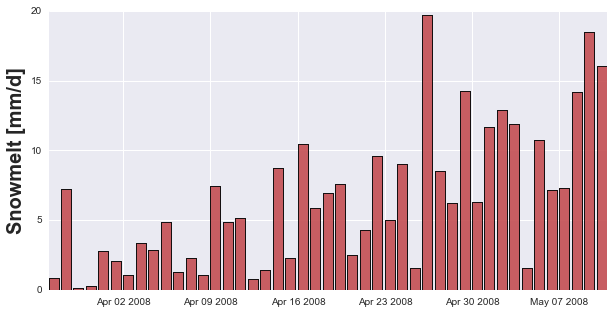

In [141]:
fig = plt.figure(figsize=(10,5))
plt.bar(sm.date, sm.sm*1000,facecolor=colors[2],lw=1,alpha=0.9)
plt.ylabel('Snowmelt [mm/d]', fontsize=20, weight='bold')
plt.savefig('./figures/snowmelt_scen.png',dpi=300,bbox_inches='tight')